In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [125]:
def square_error(data):
    return (np.subtract(data, data.mean(axis=0))**2).sum()

class KMeans():
    def __init__(self, data, seed_clusters=2, min_point=30, max_clusters=100, MCMC=False):
        self.data = np.array(data)
        self.d_n, self.dim = self.data.shape
        self.se = square_error(self.data)
        self.labels = np.zeros((self.d_n))
        self._2nd_labels = -1*np.ones((self.d_n))
        
        self.min_p = min_point
        self.max_c = max_clusters
        
        self.reset_cluster(seed_clusters)
    
    def reset_cluster(self, seed_clusters=2):
        self.clusters = np.zeros((1,self.dim))
        self.clusters[0] = self.data[np.random.randint(self.d_n)]
        if (seed_clusters>=2):
            for t in range(1, seed_clusters):
                if self.clusters.shape[0] >= self.d_n:
                    print("clusters shouldn't be more than data amounts")
                else:
                    temp_peak = self.data[np.random.randint(self.d_n)]
                    while (temp_peak in self.clusters):
                        temp_peak = self.data[np.random.randint(self.d_n)]
                    
                    self.clusters = np.vstack((self.clusters, temp_peak))
    
    def p2c(self, point):
        if len(point) != self.dim:
            print("point dimension error")
        temp_dist = (np.subtract(self.clusters, point)**2).sum(axis=1)**0.5
        return temp_dist.min()
    
    def add_cluster(self, lots = None ,MCMC_times = 0, MCMC_power = 1):
        if lots==None:
            lots = self.data
        temp_peak = lots[np.random.randint(len(lots))]
        temp_dist = self.p2c(temp_peak)
        if MCMC_times > 0:
            for t in range(MCMC_times):
                backup_peak = lots[np.random.randint(len(lots))]
                if np.random.rand()*temp_dist**MCMC_power <= self.p2c(backup_peak)**MCMC_power:
                    temp_peak = backup_peak
        
        self.clusters = np.vstack((self.clusters, temp_peak))
    
    def assign(self, only_label = True):
        self.distance = np.zeros((self.d_n, self.clusters.shape[0]))
        for c in range(self.clusters.shape[0]):
            temp_relate = np.subtract(self.data, self.clusters[c])
            self.distance[:,c] = (0.0001 + (temp_relate**2).sum(axis=1))**0.5
        
        temp_dis_sort = np.argsort(self.distance, axis=1)
        self.labels = temp_dis_sort[:, 0]
        
        if not only_label:
            if self.clusters.shape[0] >=2:
                self._2nd_labels = temp_dis_sort[:, 1]
            else:
                self._2nd_labels = -1*np.ones((self.d_n))
            
            self.c_se = np.zeros((self.clusters.shape[0]))
            self.c_std = np.zeros((self.clusters.shape[0]))
            for c in range(self.clusters.shape[0]):
                if (self.labels == c).sum() > 0:
                    self.c_se[c] = square_error(np.compress(self.labels == c, self.data, axis=0))
                    self.c_std[c] = self.c_se[c]/(self.labels == c).sum()
            
            self.c_std = np.sqrt(0.0001 + self.c_std)
            self.c_dist_cfd = np.zeros((self.clusters.shape[0], 20))
            for c in range(self.clusters.shape[0]):
                temp_c_d = np.subtract(np.compress(self.labels == c, self.data, axis=0), self.clusters[c])
                temp_c_d = np.sqrt(0.0001+(temp_c_d**2).sum(axis=1))/ self.c_std[c]
                for i in range(20):
                    self.c_dist_cfd[c][i] = (temp_c_d < ((i+1)/10)).sum()
                
                self.c_dist_cfd[c] /= (self.labels == c).sum() + 0.0001
    
    def single_fit(self, only_label=True):
        for c in range(self.clusters.shape[0]):
            if (self.labels == c).sum() > 0:
                self.clusters[c] = np.compress(self.labels == c, self.data, axis=0).mean(axis=0)
        
        self.assign(only_label)
    
    def fit(self, max_times=10):
        for t in range(max_times):
            temp_pre_lables = self.labels
            self.single_fit()
            if np.abs(self.labels - temp_pre_lables).sum() == 0:
                break
        
        self.single_fit(only_label=False)


[0, 0] 1
[ -1.56581817  19.78427954] 0.9967751212250935
[ 13.44515404  15.20846075] 1.021326455088943
[  4.75332632  10.16317952] 0.5182507422071781


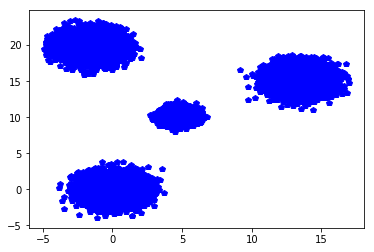

In [127]:
foo = np.random.normal(0,1,(10000,2))
print([0,0],1)
for t in range(1,4):
    c = np.random.rand((2))*40 - 20
    s = np.random.rand() + 0.1
    foo = np.vstack((foo, np.random.normal(0,s, (10000,2)) + c))
    print(c,s)

plt.plot(foo.T[0], foo.T[1] , "bp")
plt.show()

In [178]:
k_mean = KMeans(foo, seed_clusters=1)
k_mean.assign()

In [165]:
print(k_mean.clusters)
print((k_mean.c_se/2000)**0.5)

[[ 0.58518966  0.7870481 ]]
[ 0.99280174]


In [179]:
for c in range(2,10):
    k_mean = KMeans(foo, seed_clusters=c)
    k_mean.fit()
    print (k_mean.c_se.sum()/k_mean.se)

0.361720336733
0.186763208002
0.116923291704
0.0794461027854
0.0626397504897
0.046014208309
0.0370447131047
0.0335306556573


In [159]:
k_mean = KMeans(foo, seed_clusters=1)
k_mean.fit()
print (k_mean.c_se.sum()/k_mean.se)
for c in range(1,4):
    k_mean.add_cluster(MCMC_times=10)
    k_mean.fit(30)
    print (k_mean.c_se.sum()/k_mean.se, k_mean.clusters.shape[0])

print(k_mean.clusters)

1.0
0.610651027287 2
0.158730535124 3
0.0184497062156 4
[[ -5.36475122e-04   4.15624181e-03]
 [ -1.56975957e+00   1.97791585e+01]
 [  4.75551986e+00   1.01708311e+01]
 [  1.34501472e+01   1.51932724e+01]]


In [123]:
(k_mean.c_dist_cfd[0]*100).astype(int)

array([ 0,  4,  8, 15, 23, 32, 43, 52, 59, 66, 71, 76, 81, 85, 88, 91, 93,
       94, 95, 97])

In [34]:
def erf(x, Taylor=100):
    temp = x*np.sqrt(0.5)
    output = 0
    for t in range(Taylor+1):
        output += temp/(2*t+1)
        temp *= -(x**2)/(2*t+2)
    
    return 2*output/np.sqrt(np.pi)

In [103]:
for i in range(30):
    print(erf((i+1)/10))

0.0796556745541
0.158519418878
0.235822844378
0.310843483221
0.382924922548
0.4514937645
0.516072695554
0.576289202833
0.631879749306
0.682689492137
0.728667878107
0.769860659557
0.806399030829
0.838486681532
0.866385597462
0.890401416601
0.910869074483
0.928139361774
0.942566880368
0.954499736104
0.964271158874
0.972193104973
0.978551779957
0.983604928151
0.987580669348
0.990677623953
0.993066052394
0.994889739339
0.996268373399
0.997300203937


In [55]:
np.sqrt(8/10)/2

0.44721359549995793

In [62]:
for d in range(1, 101):
    print((d/(d+2))**(d/2))

0.5773502691896257
0.5
0.46475800154489
0.4444444444444444
0.43120115037169215
0.421875
0.4149486509808663
0.4096000000000001
0.4053444297059028
0.401877572016461
0.3989985621840896
0.3965694566039659
0.39449236848387353
0.39269590377807617
0.39112676195874924
0.3897443431289457
0.3885171762512141
0.3874204890000001
0.38643451492560255
0.38554328942953164
0.3847337773979006
0.38399523056087664
0.38331870695169556
0.3826967066770909
0.38212289242194547
0.3815918725444636
0.3810990309947884
0.38064039267229743
0.3802125158946246
0.37981240581524567
0.3794374441774658
0.37908533191793603
0.3787540419583015
0.37844178013552593
0.3781469526795031
0.3778681389925445
0.3776040687489516
0.37735360253530725
0.3771157154088039
0.3768894828730003
0.3766740688662258
0.3764687154334925
0.3762727338129093
0.376085496715603
0.3759064316167685
0.3757350149066323
0.3755707667754264
0.3754132467271021
0.375262049633418
0.3751168022539645
0.37497716015917026
0.3748428050028713
0.3747134420989778
0.374588

In [64]:
foo = np.arange(6).reshape(3,2)

array([1, 5, 9])